#### SISTEMA MULTIAGENTE CON LOS AGENTES DESARROLLADOS EN LOS PUNTOS 7, 8 Y 11
El punto 6 no se tuvo en cuenta como agente individual debido a que su funcion o su prompt es casi que parecido a los agentes del punto 7 y 8.

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from typing import Dict, List, Annotated, TypedDict, Literal

from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate, ChatPromptTemplate
from langchain.output_parsers.openai_tools import JsonOutputKeyToolsParser

from langgraph.graph import StateGraph, START, END

from pydantic import BaseModel, Field

In [3]:
import sys 

# Añadir la ruta completa al folder 'punto_8'
ruta_punto_8 = os.path.abspath('../punto_8')
print("Ruta añadida:", ruta_punto_8)  # Esto imprime la ruta para que verifiques
sys.path.append(ruta_punto_8)

# Intentar importar
from agente_cargos_no_reconocidos import AgentCargosNoReconocidos



Ruta añadida: c:\pt_ing_prompt\punto_8


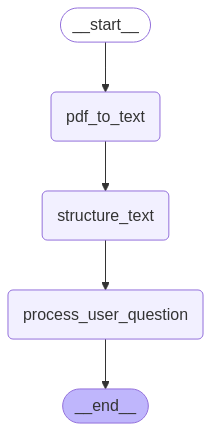

In [4]:
agente = AgentCargosNoReconocidos()

from IPython.display import Image, display
display(Image(agente.graph.get_graph().draw_mermaid_png()))

In [6]:
# Añadir la ruta completa al folder 'punto_7'
ruta_punto_7 = os.path.abspath('../punto_7')
print("Ruta añadida:", ruta_punto_7)  # Esto imprime la ruta para que verifiques
sys.path.append(ruta_punto_7)

# Intentar importar
from agente_dudas_frecuentes import AgentDudasFrecuentes



Ruta añadida: c:\pt_ing_prompt\punto_7


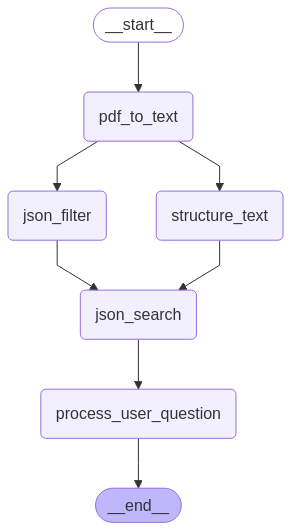

In [7]:
agente_dudas_fecuentes = AgentDudasFrecuentes()

from IPython.display import Image, display
display(Image(agente_dudas_fecuentes.graph.get_graph().draw_mermaid_png()))

In [8]:
# Añadir la ruta completa al folder 'punto_11'
ruta_punto_11 = os.path.abspath('../punto_11')
print("Ruta añadida:", ruta_punto_11)  # Esto imprime la ruta para que verifiques
sys.path.append(ruta_punto_11)

# Intentar importar
from agente_detector_IA import DetectorIA



Ruta añadida: c:\pt_ing_prompt\punto_11


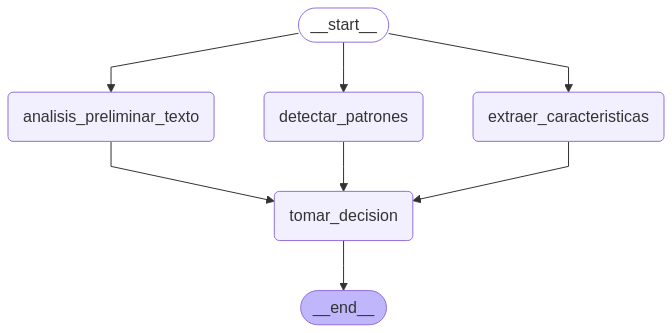

In [9]:
agente_detector_ia = DetectorIA()

from IPython.display import Image, display
display(Image(agente_detector_ia.graph.get_graph().draw_mermaid_png()))

In [10]:
class OverallState(TypedDict):
    instrucciones: str
    agente: str
    resultado: str
    pdf_path: str
    prompt: str

In [11]:
def agent_decition(state: OverallState) -> OverallState:
    """Segun el query del usuario rutearlo al agente mas apropiado"""
    
    class Agent(BaseModel):
        agent: Literal["cargos_no_reconocidos", "preguntas_frecuentes", "detector_ia"] = Field(..., description="Agente al que se le asigna la tarea") 
    
    llm = ChatOpenAI(
        temperature=0, 
        model="gpt-4o-mini"
    )
    
    llm = llm.bind_tools(tools=[Agent], tool_choice="Agent")
    parser = JsonOutputKeyToolsParser(key_name="Agent", first_tool_only=True)
    
    prompt_template = """
    Analiza el siguiente texto o query ingresado por un usuario y determina a qué agente de los siguientes se le debe asignar la tarea:
    
    - Cargos no reconocidos: Agente especializado en resolver problemas relacionados con cargos o transaccciones no reconocidos en extractos bancarios.
    - Preguntas frecuentes: Agente especializado en responder preguntas frecuentes sobre el extracto bancario.
    - Detector de IA: Agente especializado en detectar si el texto fue generado por una IA o por un humano.
    
    El texto o query es el siguiente:
    <texto>
    {texto}
    </texto>
    """
    
    prompt = PromptTemplate.from_template(
        template=prompt_template,
        partial_variables={"texto": state['instrucciones']}
    )
    
    chain = prompt | llm | parser
    
    response = chain.invoke({})["agent"]
    
    return {"agente": response}
    

In [12]:
def route_agent(state: OverallState) -> str:
    """Determinar el agente al que se le asigna la tarea"""
    
    agent = state["agente"]
    
    if agent == "cargos_no_reconocidos":
        # Asignar la tarea al agente de cargos no reconocidos
        return "cargos_no_reconocidos"
    
    elif agent == "preguntas_frecuentes":
        # Asignar la tarea al agente de preguntas frecuentes
        return "preguntas_frecuentes"
    
    elif agent == "detector_ia":
        # Asignar la tarea al agente detector de IA
        return "detector_ia"
    
    

In [13]:
graph = StateGraph(OverallState)

# Añadir nodos
graph.add_node("agent_decition", agent_decition)
graph.add_node("agente_cargos_no_reconocidos", agente.graph)
graph.add_node("agente_preguntas_frecuentes", agente_dudas_fecuentes.graph)
graph.add_node("agente_detector_ia", agente_detector_ia.graph)

graph.add_edge(START, "agent_decition")

graph.add_conditional_edges("agent_decition", route_agent, {
    "cargos_no_reconocidos": "agente_cargos_no_reconocidos",
    "preguntas_frecuentes": "agente_preguntas_frecuentes",
    "detector_ia": "agente_detector_ia"
})

graph.add_edge("agente_cargos_no_reconocidos", END)
graph.add_edge("agente_preguntas_frecuentes", END)
graph.add_edge("agente_detector_ia", END)

app = graph.compile()

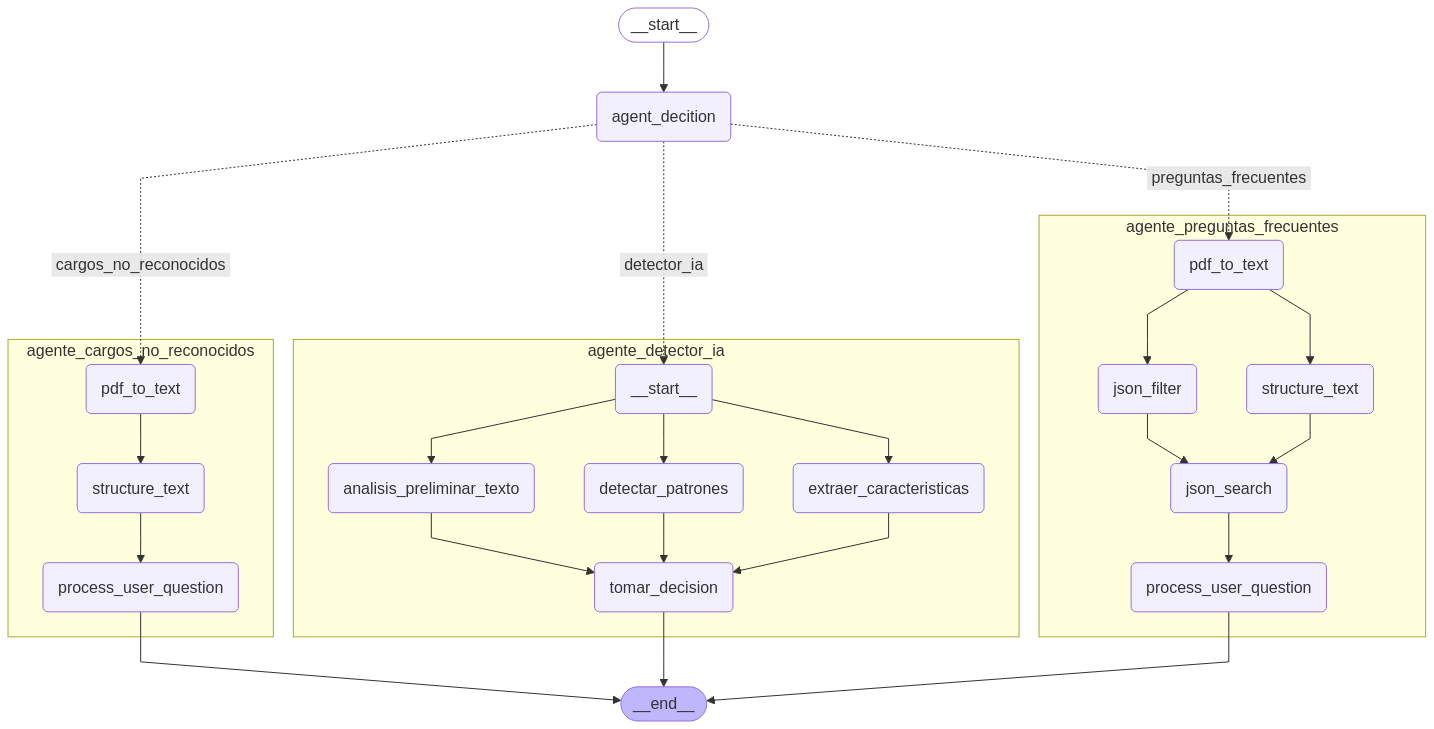

In [15]:
from IPython.display import Image, display
display(Image(app.get_graph(xray=1).draw_mermaid_png()))

In [17]:
with open('..\punto_8\prompt_no_CoT.txt', 'r', encoding='utf-8') as f:
        prompt_no_cot = f.read()
        
with open('..\punto_8\prompt_CoT.txt', 'r', encoding='utf-8') as f:
    prompt_cot = f.read()
    
# Define el estado inicial
initial_state = {
    "instrucciones": "¿La transaccion en mi extracto con numero de doc 0913 o 913 de cuanto fue su valor?",
    "pdf_path": "C:\pt_ing_prompt\data\EXTRACTO_portafolio2025033120018008910224_unlocked.pdf",
    "prompt": prompt_cot
}

# Ejecuta el agente
result = app.invoke(initial_state)

<>:1: SyntaxWarning: invalid escape sequence '\p'
<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:10: SyntaxWarning: invalid escape sequence '\p'
<>:1: SyntaxWarning: invalid escape sequence '\p'
<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:10: SyntaxWarning: invalid escape sequence '\p'
C:\Users\ypumarejo\AppData\Local\Temp\ipykernel_45180\2804278639.py:1: SyntaxWarning: invalid escape sequence '\p'
  with open('..\punto_8\prompt_no_CoT.txt', 'r', encoding='utf-8') as f:
C:\Users\ypumarejo\AppData\Local\Temp\ipykernel_45180\2804278639.py:4: SyntaxWarning: invalid escape sequence '\p'
  with open('..\punto_8\prompt_CoT.txt', 'r', encoding='utf-8') as f:
C:\Users\ypumarejo\AppData\Local\Temp\ipykernel_45180\2804278639.py:10: SyntaxWarning: invalid escape sequence '\p'
  "pdf_path": "C:\pt_ing_prompt\data\EXTRACTO_portafolio2025033120018008910224_unlocked.pdf",


In [18]:
result["resultado"]

'He analizado su consulta sobre el cargo con el número de documento 913. Vamos a examinarlo paso a paso:\n\nAl revisar su extracto, observo lo siguiente:\n- La transacción con el número de documento 913 fue realizada el 01 de marzo.\n- El valor de esta transacción fue de 100,000.\n- La clase de movimiento es "Transferencia Enviada" y se realizó a través de la oficina "A Daviplata App Davivienda".\n\nConsiderando todos estos elementos, puedo determinar que:\n\nEste cargo corresponde a una transferencia enviada desde su cuenta a través de la aplicación Daviplata de Davivienda. El monto de 100,000 es consistente con una transacción de este tipo, que generalmente se utiliza para enviar dinero a otras cuentas o personas.\n\nSi tiene más preguntas o necesita más detalles sobre esta transacción, no dude en preguntar.'